<a href="https://colab.research.google.com/github/Bareera2505/Deep-Learning-Labs/blob/main/Lab5BM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
from sklearn.model_selection import train_test_split
import zipfile
import glob
from PIL import Image
import cv2 as cv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

1
Tesla T4


In [5]:
batch_size = 100
learning_rate=0.0001

In [6]:

base_dir = '/content/drive/MyDrive/Colab Notebooks/'
train_dir = '/content/drive/MyDrive/Colab Notebooks/train/'
test_dir = '/content/drive/MyDrive/Colab Notebooks/test/'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f'Length of training data: {len(train_list)}')
print(f'Length of test data: {len(test_list)}')
train_list, val_list = train_test_split(train_list, test_size=0.2)
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

val_transforms = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms_not_normalized = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
test_data_not_normalized = dataset(test_list, transform=test_transforms_not_normalized)
val_data = dataset(val_list, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)
test_loader_not_normalized = torch.utils.data.DataLoader(dataset = test_data_not_normalized, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

#Took help from these resources for data loading
#https://www.kaggle.com/code/lys620/basic-pytorch-cnn-tutorial/notebook


Length of training data: 25000
Length of test data: 12500


In [7]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
        
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


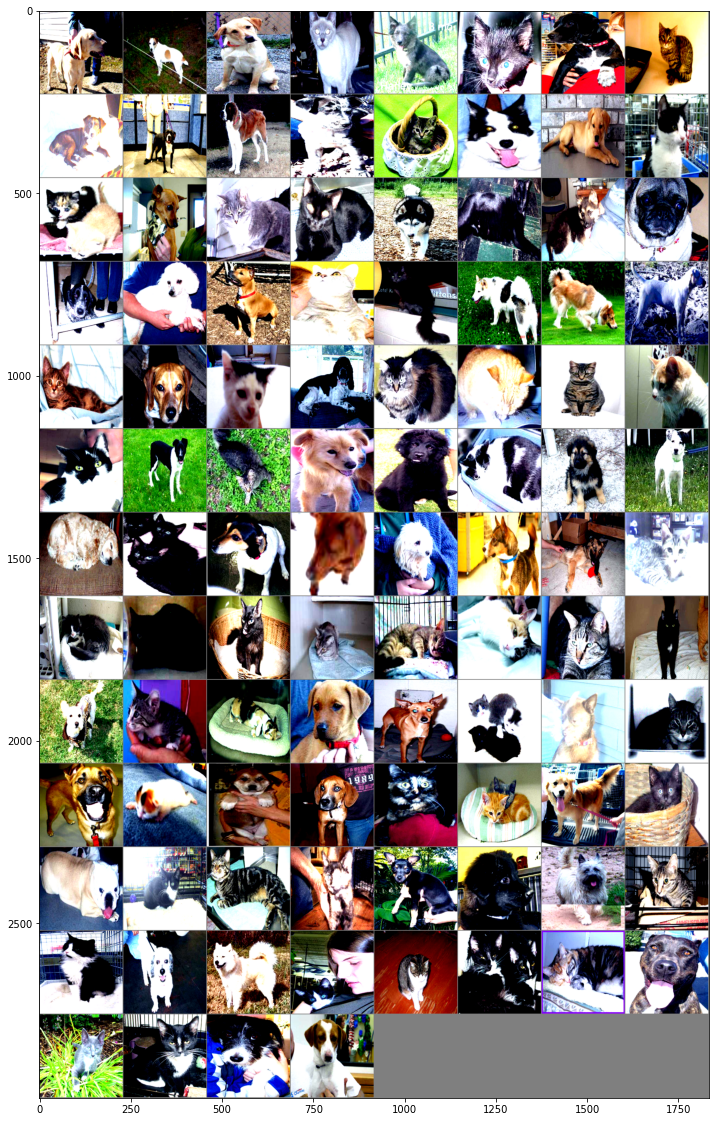

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

In [9]:
#conv_list = [0,3,6,8,10]
#fc_list = [1,4,6]
#for i in conv_list:
    #torch.nn.init.kaiming_normal_(Alexnet.features[i].weight)
#for i in fc_list:
    #torch.nn.init.kaiming_normal_(Alexnet.classifier[i].weight)


In [10]:
%%time
import time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [11]:
#Definition of hyperparameters
model = AlexNet().to(cuda0)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss() 

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs=6

In [12]:
# initialize arrays to hold loss and accuracy data
train_loss_list = np.zeros((num_epochs,))
accuracy_list = np.zeros((num_epochs,))

for epoch in tqdm.trange(num_epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    imgs = imgs.to(cuda0)
    labels = labels.to(cuda0)
    y_pred = model(imgs).to(cuda0)
    loss = error(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)


  # Calculate accuracy
  imgs_test, labels_test = next(iter(val_loader))
  imgs_test = imgs_test.to(cuda0)
  labels_test = labels_test.to(cuda0)
  #labels_test = labels_test.type(torch.FloatTensor).to(cuda0)
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()
  print(f'Epoch: {epoch+1}, Training Loss: {train_loss_list[epoch]:0.5f}, Accuracy: {accuracy_list[epoch]:0.5f}')

 17%|█▋        | 1/6 [1:49:27<9:07:17, 6567.54s/it]

Epoch: 1, Training Loss: 0.61059, Accuracy: 0.74000


 33%|███▎      | 2/6 [1:51:56<3:06:06, 2791.75s/it]

Epoch: 2, Training Loss: 0.46347, Accuracy: 0.81000


 50%|█████     | 3/6 [1:54:28<1:19:19, 1586.35s/it]

Epoch: 3, Training Loss: 0.37839, Accuracy: 0.92000


 67%|██████▋   | 4/6 [1:56:57<33:57, 1018.86s/it]  

Epoch: 4, Training Loss: 0.32612, Accuracy: 0.88000


 83%|████████▎ | 5/6 [1:59:23<11:44, 704.17s/it] 

Epoch: 5, Training Loss: 0.27476, Accuracy: 0.84000


100%|██████████| 6/6 [2:01:50<00:00, 1218.35s/it]

Epoch: 6, Training Loss: 0.24896, Accuracy: 0.86000


Text(0.5, 0.98, 'Optimizer: Adam \n lr = 0.001 epochs = 6 \n Max Accuracy = 0.920')

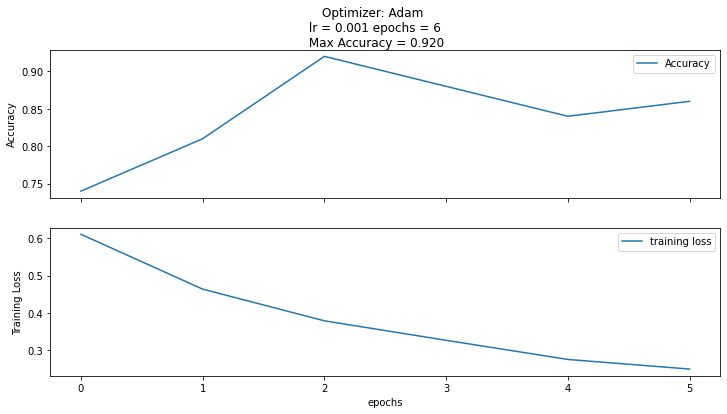

In [15]:
# plot test accuracy and training loss
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list,label='Accuracy')
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(train_loss_list,label='training loss')
#ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Optimizer: Adam \n lr = 0.001 epochs = {num_epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [23]:
model_save_name = 'classifier.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

In [16]:
# get images and labels for test set
imgs_test, labels_test = next(iter(test_loader))
imgs_test = imgs_test.to(cuda0)
with torch.no_grad():
  y_pred = model(imgs_test)

In [17]:
# get guesses
guesses = torch.argmax(y_pred, dim=1) 

# get probabilities
smax=nn.Softmax(dim=1)
probability,_ = torch.max(smax(y_pred),dim=1) 

imgs_test_not_normalized, labels_test_not_normalized = next(iter(test_loader_not_normalized))

Text(0.5, 0.98, 'AlexNet Cat/Dog Classification Test')

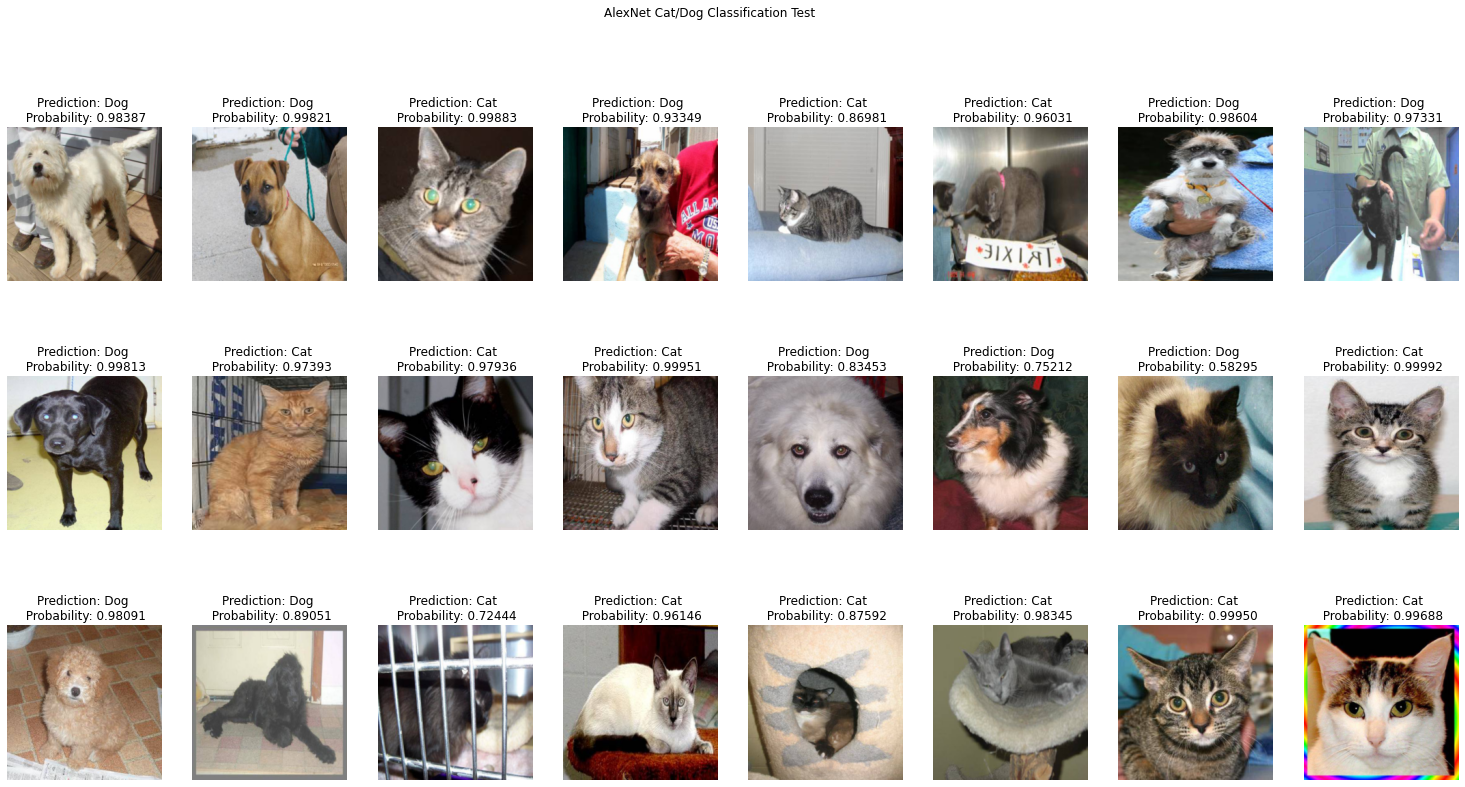

In [18]:
# plot classification accuracy
f,ax=plt.subplots(3,8,figsize=(26,13))
for i,(axs,predicted,true,prob) in enumerate(zip(ax.reshape(-1),guesses,labels_test,probability)):
  axs.imshow(imgs_test_not_normalized[i].permute(1,2,0))
  if predicted == 1:
            predicted='Dog'
  elif predicted == 0:
            predicted='Cat'
  axs.set_title(f'Prediction: {predicted} \n Probability: {prob:0.5f}')
  axs.axis('off')
f.suptitle('AlexNet Cat/Dog Classification Test')

# **VISUALIZATION**

In [19]:
# load the model
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())
model_children = model_children[0] 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
      counter += 1
      model_weights.append(model_children[i].weight)
      conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
      print('hi again')
      for j in range(len(model_children[i])):
          for child in model_children[i][j].children():
              if type(child) == nn.Conv2d:
                  counter += 1
                  model_weights.append(child.weight)
                  conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 5


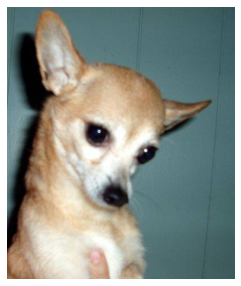

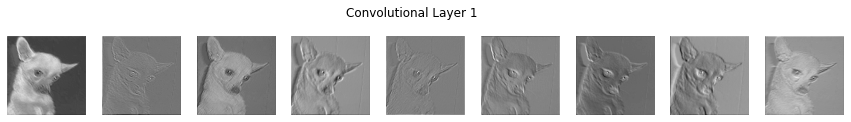

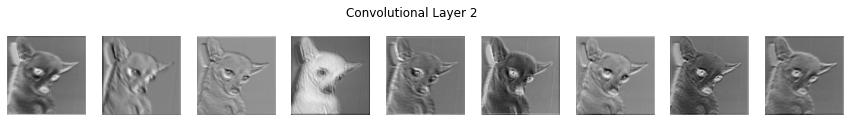

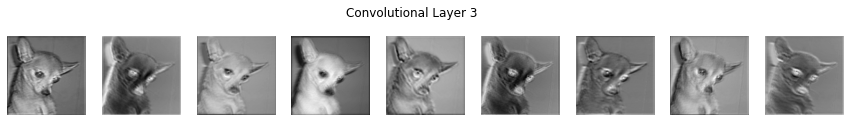

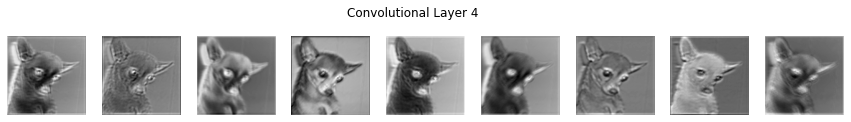

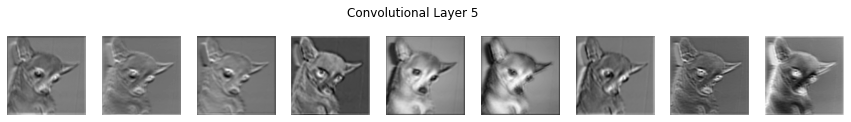

In [21]:
# read and visualize an image
img = cv.imread(train_list[3])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
f,ax=plt.subplots(figsize=(15,5))
ax.imshow(img)
ax.axis('off')
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img).to(cuda0)

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)

# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(15, 2))
    plt.suptitle(f'Convolutional Layer {num_layer+1}')
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    for i, filter in enumerate(layer_viz):
        if i == 9: # we will visualize only 9 feature maps in each layer
            break
        plt.subplot(1, 9, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")